# Case Study 3

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.

#### Requirements

  * compare at least 2 feature selection methods (groups of 5-6: at least 4)
    - filtering methods (at least one scoring function)
    - wrapper methods (at least one, e.g., forward feature selection or backward feature elimination)
    - embedding methods  (at least one, e.g., L1 regularisation)
 * combine each method with at least 2 classifiers 
   (justify your choice of classifiers in the report)
    - SVM
    - KNN
    - ...
  * perform Leave-one-group-out cross-validation, where all 10 samples from each subject are in one group (18 groups in total)
  * use cross-validation to optimise hyper-parameter values
  * as a baseline for comparison, evaluate each of your classifiers trained on the full set of features (trained without feature selection)




In [78]:
import csv
import numpy as np

from matplotlib import pyplot as plt

In [79]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

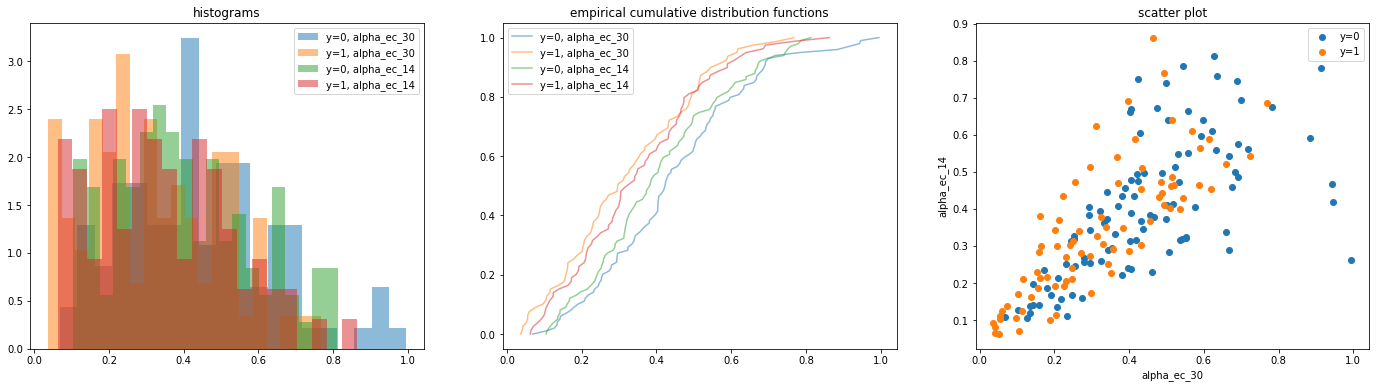

In [80]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
f0, f1 = np.random.randint(0, num_features, size=2)
e = np.random.randint(0, num_electrodes)
i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
f = np.random.randint(0, num_features)
e0, e1 = np.random.randint(0, num_electrodes, size=2)
i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn import svm
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import math
#importing libraries necessary to perform the forward selection, back selection ,  performance matrix, plot and classification.
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [5]:
features = pd.read_csv("feature_names.csv")
X = pd.read_csv("data.csv",header=None)
X.columns = features.columns
print(X.head())
y = pd.read_csv("labels.csv",header=None).to_numpy().ravel()
print(y.shape)
X_train , X_test , y_train, y_test = train_test_split(X,y, test_size = 0.1,random_state = 36)

   alpha_ec_0  alpha_ec_1  alpha_ec_2  alpha_ec_3  alpha_ec_4  alpha_ec_5  \
0     0.11184     0.12387     0.12858     0.11324     0.10571     0.10690   
1     0.29834     0.26881     0.26239     0.38009     0.34358     0.28500   
2     0.36912     0.39587     0.38999     0.25772     0.40554     0.44199   
3     0.76120     0.77726     0.77042     0.60161     0.70183     0.72725   
4     0.16770     0.15146     0.14714     0.15728     0.14965     0.14154   

   alpha_ec_6  alpha_ec_7  alpha_ec_8  alpha_ec_9  ...  ratio_theta_38  \
0     0.10756     0.11064     0.10875     0.15893  ...         0.57161   
1     0.24791     0.25033     0.26047     0.26016  ...         0.35142   
2     0.44004     0.39947     0.31546     0.28348  ...         0.61924   
3     0.76245     0.78904     0.72984     0.52236  ...         0.23456   
4     0.13228     0.12760     0.14351     0.17252  ...         1.82160   

   ratio_theta_39  ratio_theta_40  ratio_theta_41  ratio_theta_42  \
0         0.73870      

In [8]:
#Testing original dataset on support vector machine classifier before Feature Selection
svc = svm.SVC(kernel = 'rbf', C=1)
svc.fit(X_train,y_train)
y_svm = svc.predict(X_test)
print("SVM classification report Before applying Feature Engineering")
print(classification_report(y_test,y_svm))
scores_svm_before = cross_val_score(svc , X,y,cv = 10)
print("Average SVM Classifier accuracy before "+ str(round(100*scores_svm_before.mean(),2)))

SVM classification report Before applying Feature Engineering
              precision    recall  f1-score   support

         0.0       0.78      0.64      0.70        11
         1.0       0.56      0.71      0.63         7

    accuracy                           0.67        18
   macro avg       0.67      0.68      0.66        18
weighted avg       0.69      0.67      0.67        18

Average SVM Classifier accuracy before 76.67


In [10]:
#Testing original dataset on K Nearest Neighbour classifier before Feature Selection

#for K-value of KNN classifier +/- 1 of sqrt(datapoints) i.e.,
#y_test is used (whichever is odd to avoid confusion between two classes)

k = int(math.sqrt(len(y_test)))
if (k%2 ==0):
    k = k+1
knn = KNeighborsClassifier(n_neighbors=k, p =2)
knn.fit(X_train,y_train)
y_knn = knn.predict(X_test)
print("KNN classification report Before applying Feature Engineering")
print(classification_report(y_test,y_knn))
scores_knn_before = cross_val_score(knn , X,y,cv = 10)
print("Average KNN Classifier accuracy before "+ str(round(100*scores_knn_before.mean(),2)))

KNN classification report Before applying Feature Engineering
              precision    recall  f1-score   support

         0.0       0.75      0.82      0.78        11
         1.0       0.67      0.57      0.62         7

    accuracy                           0.72        18
   macro avg       0.71      0.69      0.70        18
weighted avg       0.72      0.72      0.72        18

Average KNN Classifier accuracy before 72.78


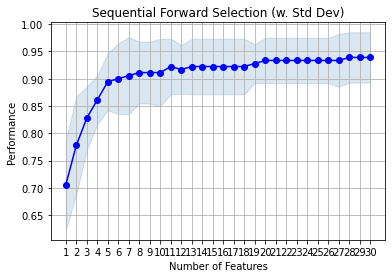

In [127]:
estimator = KNeighborsClassifier(n_neighbors=7,p=2)

  
sfs = SFS(estimator, 
           k_features=30, 
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=10)

sfs = sfs.fit(X,y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. Std Dev)')
plt.grid()
plt.show()

#Plotted the performance matrix for N number of features and from visualization 28 seems to be the ideal number of features for 
#best subset of feature selection

In [84]:
#wrap = SequentialFeatureSelector(estimator,direction = 'forward',scoring = None,cv=10,n_jobs=-1).fit(X,y)
'''sfs1 = SFS(estimator, 
           k_features=28, 
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=10)
sfs1 = sfs1.fit(X,y)
X_train_new = sfs1.transform(X_train)
X_test_new = sfs1.transform(X_test)
X_new = sfs1.transform(X)
svc.fit(X_train_new,y_train)
y_pred = svc.predict(X_test_new)
acc = float((y_test == y_pred).sum()) / y_pred.shape[0]
print(acc)
scores_wrap = cross_val_score(svc,X_new,y,cv=10)
print(scores_wrap.mean())'''

"sfs1 = SFS(estimator, \n           k_features=28, \n           forward=True, \n           floating=False, \n           scoring='accuracy',\n           cv=10)\nsfs1 = sfs1.fit(X,y)\nX_train_new = sfs1.transform(X_train)\nX_test_new = sfs1.transform(X_test)\nX_new = sfs1.transform(X)\nsvc.fit(X_train_new,y_train)\ny_pred = svc.predict(X_test_new)\nacc = float((y_test == y_pred).sum()) / y_pred.shape[0]\nprint(acc)\nscores_wrap = cross_val_score(svc,X_new,y,cv=10)\nprint(scores_wrap.mean())"

In [35]:
selector = SelectFromModel(LogisticRegression(C=0.24, penalty='l1', solver='liblinear',max_iter=1000,verbose=1))
selector.fit(X_train, y_train)
support = selector.get_support()
data_cols = list(X.columns)
X_train_l1 = selector.transform(X_train)
X_test_l1 = selector.transform(X_test)
X_l1 = selector.transform(X)
print("Features selected are: ")
for i in range(432):
    if support[i]==True:
        print(data_cols[i],end=", ") 
print()
print("Number of Features selected are: " + str(X_train_l1.shape[1]))

svc.fit(X_train_l1,y_train)
y_predl1 = svc.predict(X_test_l1)
print()
print()
print("SVM classification report After Embedded ")
print(classification_report(y_test,y_predl1))
scores_l1 = cross_val_score(svc, X_l1,y,cv = 10)
print("Accuracy of SVM " +str(round(100*scores_l1.mean(),2)))
print("----------------------------------------------------------------------------------------")
knn.fit(X_train,y_train)
y_predl2 = knn.predict(X_test)
print("KNN classification report after embedded")
print(classification_report(y_test,y_predl2))
scores_l2 = cross_val_score(knn , X_l1,y,cv = 10)
print("Average KNN Classifier accuracy "+ str(round(100*scores_l2.mean(),2)))

[LibLinear]Features selected are: 
ratio_alpha_3, ratio_alpha_5, ratio_alpha_9, ratio_alpha_24, ratio_alpha_28, ratio_alpha_33, ratio_alpha_34, ratio_alpha_38, ratio_alpha_45, ratio_beta_4, ratio_beta_21, ratio_theta_19, ratio_theta_25, ratio_theta_38, 
Number of Features selected are: 14


SVM classification report After Embedded 
              precision    recall  f1-score   support

         0.0       0.78      0.64      0.70        11
         1.0       0.56      0.71      0.63         7

    accuracy                           0.67        18
   macro avg       0.67      0.68      0.66        18
weighted avg       0.69      0.67      0.67        18

Accuracy of SVM 79.44
----------------------------------------------------------------------------------------
KNN classification report after embedded
              precision    recall  f1-score   support

         0.0       0.75      0.82      0.78        11
         1.0       0.67      0.57      0.62         7

    accuracy           

In [25]:
'''selector2 = SelectFromModel(RandomForestClassifier())
selector2.fit(X_train, y_train)
#print(selector.get_support())
X_train_rf = selector2.transform(X_train)
X_test_rf = selector2.transform(X_test)
X_rf = selector2.transform(X)
svc.fit(X_train_rf,y_train)
y_pred_rf = svc.predict(X_test_rf)
scores_rf = cross_val_score(svc, X_rf,y,cv = 10)
print(scores_rf.mean())
X_train_rf.shape'''

'selector2 = SelectFromModel(RandomForestClassifier())\nselector2.fit(X_train, y_train)\n#print(selector.get_support())\nX_train_rf = selector2.transform(X_train)\nX_test_rf = selector2.transform(X_test)\nX_rf = selector2.transform(X)\nsvc.fit(X_train_rf,y_train)\ny_pred_rf = svc.predict(X_test_rf)\nscores_rf = cross_val_score(svc, X_rf,y,cv = 10)\nprint(scores_rf.mean())\nX_train_rf.shape'

In [88]:
'''X2 = pd.read_csv("data.csv")
y2 = pd.read_csv("labels.csv").to_numpy().ravel()
X2.columns = features.columns
X2_train , X2_test , y2_train, y2_test = train_test_split(X2,y2, test_size = 0.1,random_state = 0)

#for K-value of KNN classifier +/- 1 of sqrt(datapoints) i.e.,
#y_test is used (whichever is odd to avoid confusion between two classes)
k = int(math.sqrt(len(y2_test)))
if (k%2 ==0):
    k = k+1
knn = KNeighborsClassifier(n_neighbors=k, p =2)
knn.fit(X2_train,y2_train)
scores1 = cross_val_score(knn , X2,y2,cv = 10)
print(scores1.mean())
knn.fit(X_train_new,y_train)
y_pred2 = knn.predict(X_test_new)
scores2 = cross_val_score(knn, X_new,y,cv = 10)
scores2.mean()'''

'X2 = pd.read_csv("data.csv")\ny2 = pd.read_csv("labels.csv").to_numpy().ravel()\nX2.columns = features.columns\nX2_train , X2_test , y2_train, y2_test = train_test_split(X2,y2, test_size = 0.1,random_state = 0)\n\n#for K-value of KNN classifier +/- 1 of sqrt(datapoints) i.e.,\n#y_test is used (whichever is odd to avoid confusion between two classes)\nk = int(math.sqrt(len(y2_test)))\nif (k%2 ==0):\n    k = k+1\nknn = KNeighborsClassifier(n_neighbors=k, p =2)\nknn.fit(X2_train,y2_train)\nscores1 = cross_val_score(knn , X2,y2,cv = 10)\nprint(scores1.mean())\nknn.fit(X_train_new,y_train)\ny_pred2 = knn.predict(X_test_new)\nscores2 = cross_val_score(knn, X_new,y,cv = 10)\nscores2.mean()'

In [89]:
'''knn.fit(X_train_l1,y_train)
y_pred_l1 = knn.predict(X_test_l1)
scores_l1 = cross_val_score(knn, X_l1,y,cv = 10)
print(scores_l1.mean())
X_train_l1.shape'''

'knn.fit(X_train_l1,y_train)\ny_pred_l1 = knn.predict(X_test_l1)\nscores_l1 = cross_val_score(knn, X_l1,y,cv = 10)\nprint(scores_l1.mean())\nX_train_l1.shape'

In [90]:
'''knn.fit(X_train_wrap,y_train)
scores_wrap = cross_val_score(knn,X_wrap,y,cv=10)
print(scores_wrap.mean())'''

'knn.fit(X_train_wrap,y_train)\nscores_wrap = cross_val_score(knn,X_wrap,y,cv=10)\nprint(scores_wrap.mean())'

In [91]:
knn_estimator = KNeighborsClassifier(n_neighbors=7,p=2)
forward = SFS(knn_estimator,k_features='best',forward = True,n_jobs=-1)
forward.fit(X,y)

SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=7),
                          k_features=(1, 432), n_jobs=-1, scoring='accuracy')

In [137]:
f_extract = list(forward.k_feature_names_)
X_train_for = forward.transform(X_train)
X_test_for = forward.transform(X_test)
svc.fit(X_train_for,y_train)
y_pred_svm = svc.predict(X_test_for)
X_for = forward.transform(X)
print("SVM classification report After")
print(classification_report(y_test,y_pred_svm))
scores_svm_after = cross_val_score(svc,X_for,y,cv=10)
print("Average SVM Accuracy After Feature Selection " +str(round(100*scores_svm_after.mean(),2)))

print("-----------------------------------------------------------------------------------")
knn.fit(X_train_for,y_train)
y_pred_knn = knn.predict(X_test_for)
print("KNN classification report After")
print(classification_report(y_test,y_pred_knn))
scores_knn_after = cross_val_score(knn,X_for,y,cv=10)
print("Average KNN Accuracy After Feature Selection " +str(round(100*scores_knn_after.mean(),2)))
print(" ")
print(" ")
print("Extracted Features are ")
for i in f_extract:
    print(i,end=", ")
print()
print()
print("Number of features Selected out of 432 are "+str(len(f_extract)))

SVM classification report After
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87        11
         1.0       0.83      0.71      0.77         7

    accuracy                           0.83        18
   macro avg       0.83      0.81      0.82        18
weighted avg       0.83      0.83      0.83        18

Average SVM Accuracy After Feature Selection 90.0
-----------------------------------------------------------------------------------
KNN classification report After
              precision    recall  f1-score   support

         0.0       0.80      0.73      0.76        11
         1.0       0.62      0.71      0.67         7

    accuracy                           0.72        18
   macro avg       0.71      0.72      0.71        18
weighted avg       0.73      0.72      0.72        18

Average KNN Accuracy After Feature Selection 93.89
 
 
Extracted Features are 
alpha_ec_16, alpha_ec_17, alpha_ec_29, alpha_ec_30, alpha_ec_32, alph